In [1]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
diabetes_health_indicators = fetch_ucirepo(id=891) 
  
# data (as pandas dataframes) 
X = diabetes_health_indicators.data.features 
y = diabetes_health_indicators.data.targets 

In [2]:
num_rows = X.shape[0]
print("Number of rows in the dataset:", num_rows)

Number of rows in the dataset: 253680


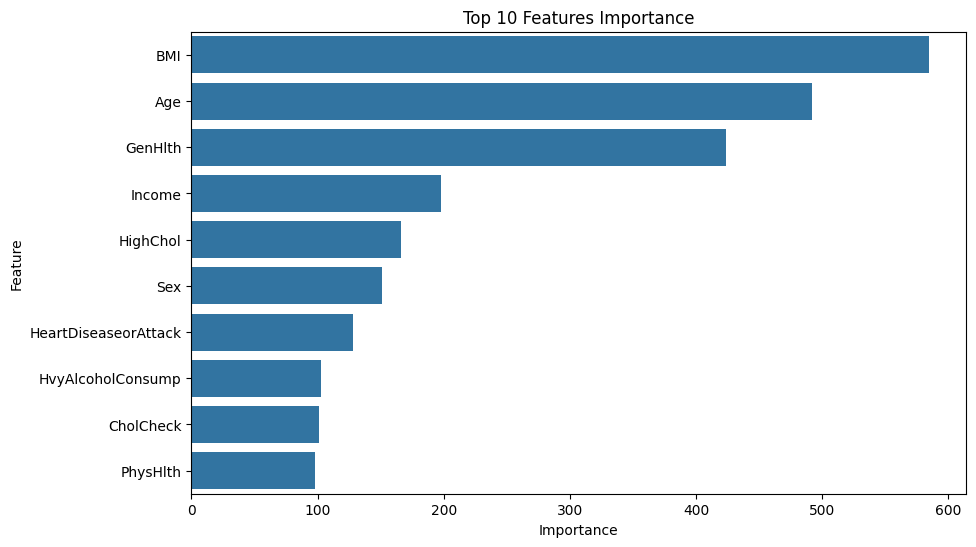

In [3]:
import lightgbm as lgb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Assuming you already have X and y defined

# Create LightGBM dataset
lgb_train = lgb.Dataset(X, label=y)

# Set parameters for LightGBM
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# Train LightGBM model
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=100,
                valid_sets=lgb_train
                )

# Get feature importance
feature_importance_df = pd.DataFrame({'Feature': gbm.feature_name(), 'Importance': gbm.feature_importance()})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Get top 10 features
top_features = feature_importance_df['Feature'].head(10)

# Filter X to keep only the top 10 features
X_top_10 = X[top_features]

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title('Top 10 Features Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [5]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'num_leaves': [25, 31, 40],
    'learning_rate': [0.2, 0.15, 0.1],
    'bagging_fraction': [0.6, 0.7, 0.5],
    'feature_fraction': [0.6, 0.3, 0.5],
    'max_depth': [-1],
    'boosting_type': ['gbdt'],
    'objective': ['binary'],
    'metric': ['binary_logloss']
}
# Create LightGBM dataset with only the top 10 features
lgb_train_top_10 = lgb.Dataset(X_top_10, label=y)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=lgb.LGBMClassifier(),
                           param_grid=param_grid,
                           scoring='neg_log_loss',  # Use negative log loss as the scoring metric
                           cv=3,  # 3-fold cross-validation
                           verbose=1,
                           n_jobs=-1)           # use all CPU cores

# Perform grid search
grid_search.fit(X_top_10, y)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)
#Best Hyperparameters: {'bagging_fraction': 0.6, 'boosting_type': 'gbdt', 'feature_fraction': 0.5, 'learning_rate': 0.1, 'max_depth': -1, 'metric': 'binary_logloss', 'num_leaves': 31, 'objective': 'binary'}

Fitting 3 folds for each of 81 candidates, totalling 243 fits


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Info] Number of positive: 35346, number of negative: 218334
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012447 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146
[LightGBM] [Info] Number of data points in the train set: 253680, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.139333 -> initscore=-1.820841
[LightGBM] [I

In [6]:
best_params['is_unbalance'] = True          # for mitigating class unbalance/bias

# Train LightGBM model with the best hyperparameters
best_gbm_top_10 = lgb.train(params=best_params,
                             train_set=lgb_train_top_10,
                             num_boost_round=100,
                             valid_sets=lgb_train_top_10
                             )


[LightGBM] [Info] Number of positive: 35346, number of negative: 218334
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 146
[LightGBM] [Info] Number of data points in the train set: 253680, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.139333 -> initscore=-1.820841
[LightGBM] [Info] Start training from score -1.820841


In [10]:
import joblib

joblib.dump(best_gbm_top_10,"lightGB_model.pkl") 

['lightGB_model.pkl']